In [353]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from re import sub
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, classification_report
from sklearn.inspection import permutation_importance

import warnings
warnings.simplefilter("ignore")
palette = sns.color_palette('coolwarm')


magnitude: Earthquake magnitude on the Richter Scale

depth: Depth where the earthquake rupture begins (in kilometers)

cdi: Maximum reported intensity for the event (community reports)

mmi: Maximum estimated instrumental intensity (measured by instruments)

sig: Significance score based on magnitude, intensity, and impact reports

alert (target variable): A categorical classification system indicating the earthquake’s alert level (e.g., green, yellow, orange, red)

The target variable (alert) is what we aim to predict. Since it is categorical with multiple classes, this problem is a multiclass classification task.



In [354]:
df = pd.read_csv('./datasets/earthquake_alert_balanced_dataset.csv')
df.describe()

,magnitude,depth,cdi,mmi,sig
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000
mean,7.061008,50.321538,6.976154,6.939231,-9.749231
std,0.423738,104.348286,2.244875,1.354774,62.245214
min,6.500000,2.000000,0.000000,1.000000,-128.000000
25%,6.700000,12.000000,6.000000,6.000000,-54.000000
50%,7.000000,19.000000,8.000000,7.000000,-7.000000
75%,7.300000,38.000000,8.000000,8.000000,31.000000
max,8.600000,670.000000,9.000000,9.000000,127.000000


In [355]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   magnitude  1300 non-null   float64
 1   depth      1300 non-null   float64
 2   cdi        1300 non-null   float64
 3   mmi        1300 non-null   float64
 4   sig        1300 non-null   float64
 5   alert      1300 non-null   object 
dtypes: float64(5), object(1)
memory usage: 61.1+ KB


In [356]:
def plot_measurements_histograms():
    fig, ax =plt.subplots(2,3, figsize=(20,25))     
    alert_palette = {
        "green": "green",
        "yellow": "yellow",
        "orange": "orange",
        "red": "red"
    }
    sns.histplot(x = df["magnitude"], hue = df["alert"], palette=alert_palette, ax=ax[0,0]);
    ax[0,0].set_xlabel("magnitude",fontsize=15)

    sns.histplot(x = df["depth"], hue = df["alert"], palette=alert_palette, ax=ax[0,1]);
    ax[0,1].set_xlabel("depth",fontsize=15)

    sns.histplot(x = df["cdi"], hue = df["alert"], palette=alert_palette, ax=ax[0,2]);
    ax[0,2].set_xlabel("cdi",fontsize=15)

    sns.histplot(x = df["mmi"], hue = df["alert"], palette=alert_palette, ax=ax[1,0]);
    ax[1,0].set_xlabel("mmi",fontsize=15)


    sns.histplot(x = df["sig"], hue = df["alert"], palette=alert_palette, ax=ax[1,1]);
    ax[1,1].set_xlabel("sig",fontsize=15)

    sns.histplot(x = df["alert"], hue = df["alert"], palette=alert_palette, ax=ax[1,2]);
    ax[1,1].set_xlabel("sig",fontsize=15)

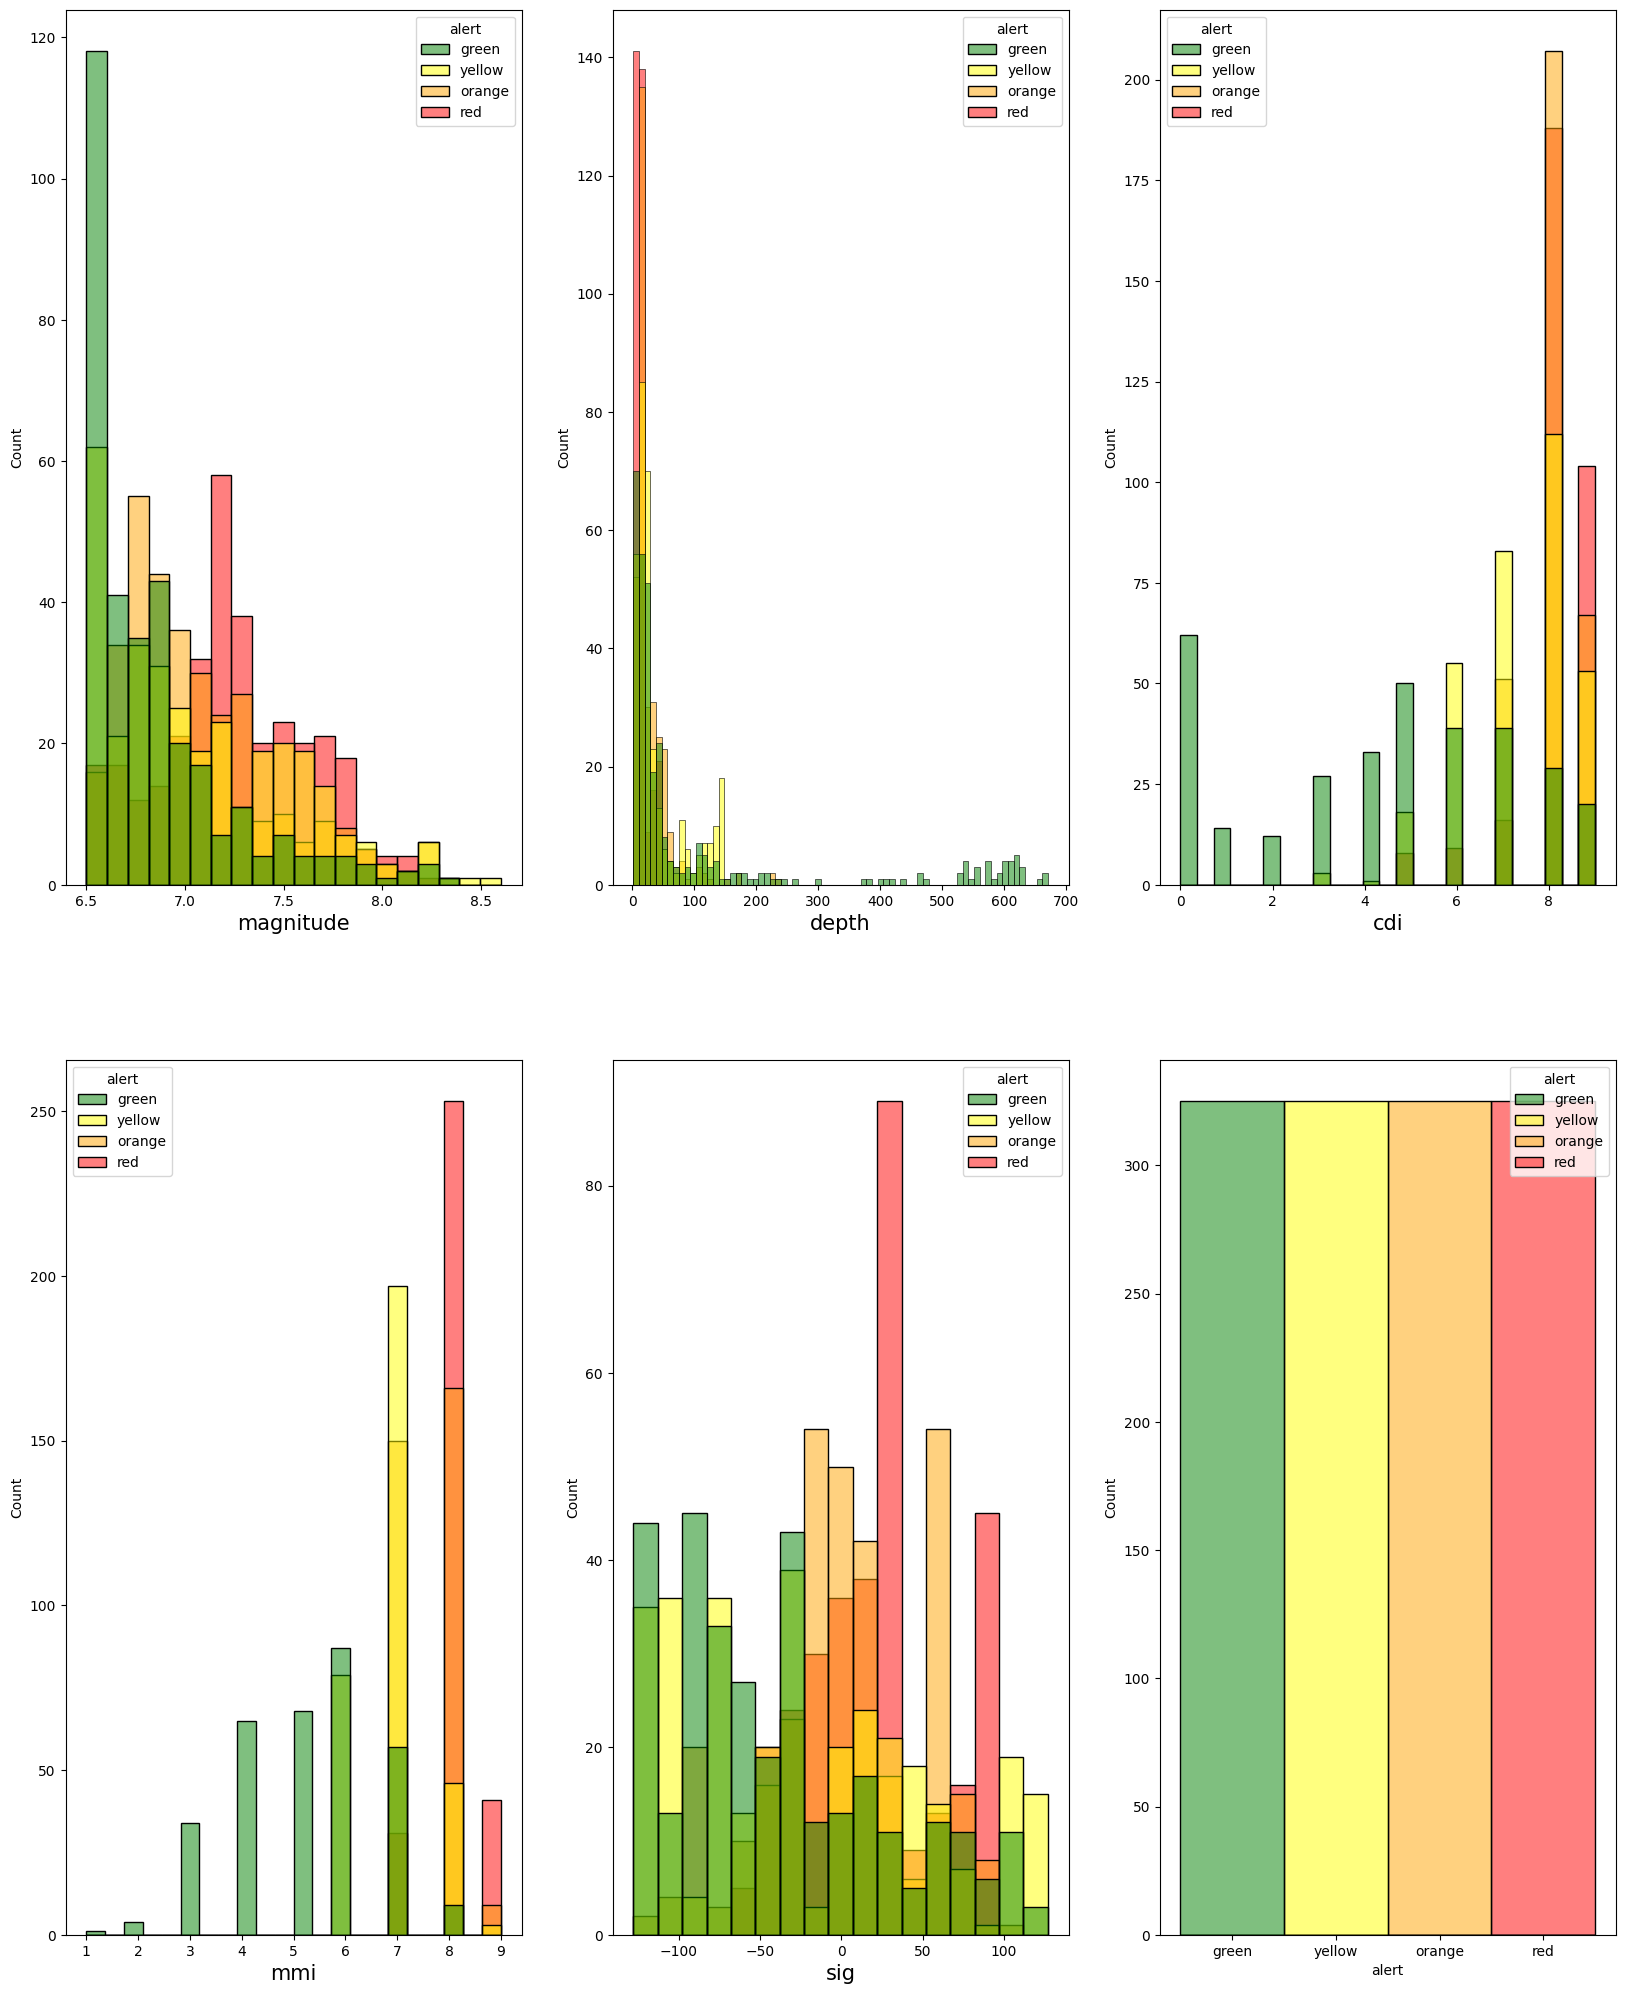

In [357]:
plot_measurements_histograms()

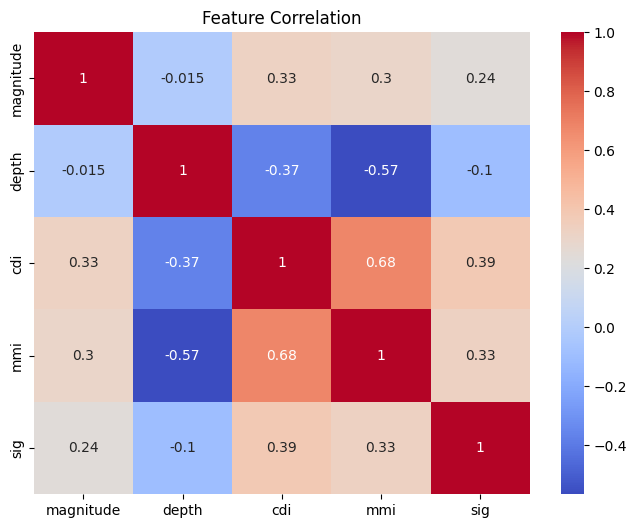

In [358]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()


cdi and mmi have a strong positive correlation (0.68), which makes sense because both measure earthquake intensity from community reports and instruments.

In [359]:
X = df.drop("alert", axis=1).copy()
y = df["alert"].copy()

In [360]:
le = LabelEncoder()
y = le.fit_transform(y)

# Target variable encoding:
#   green -> 0
#   orange -> 1
#   red -> 2
#   yellow -> 3

In [361]:
# Scale numeric features
# Standardize the feature values to have mean 0 and standard deviation 1
# This ensures all features are on the same scale, which helps many machine learning models perform better
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [362]:
# - stratify=y ensures that the class distribution of 'alert' is preserved in both sets
# - random_state=42 ensures the split is reproducible
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [363]:
clf_svm = SVC(probability=True, random_state=42, 
        kernel='rbf', C=25, gamma='scale', decision_function_shape='ovr')

clf_svm.fit(X_train_scaled, y_train)
y_pred = clf_svm.predict(X_test_scaled)


Accuracy:  0.8846153846153846
Recall:  0.8846153846153846
Precision:  0.8904733727810651
F1 Score:  0.8847793219634975


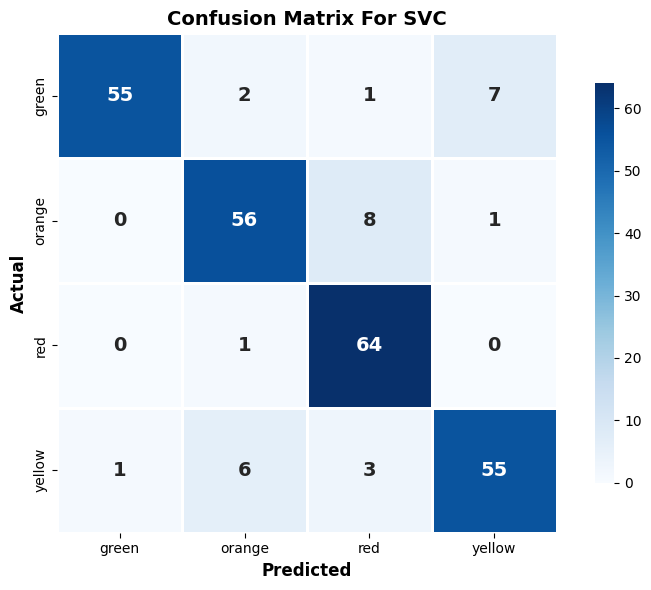

In [364]:
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ', recall_score(y_pred, y_test, average="weighted"))
print('Precision: ', precision_score(y_pred, y_test, average="weighted"))
print('F1 Score: ', f1_score(y_pred, y_test, average="weighted"))

# Convert numeric labels back to string labels for visualization
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", 
            vmin=0, vmax=None, square=True, linewidths=2, 
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={"shrink": 0.8}, annot_kws={"size": 14, "weight": "bold"})
plt.title("Confusion Matrix For SVC", fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

Text(0.5, 0, 'Permutation Importance')

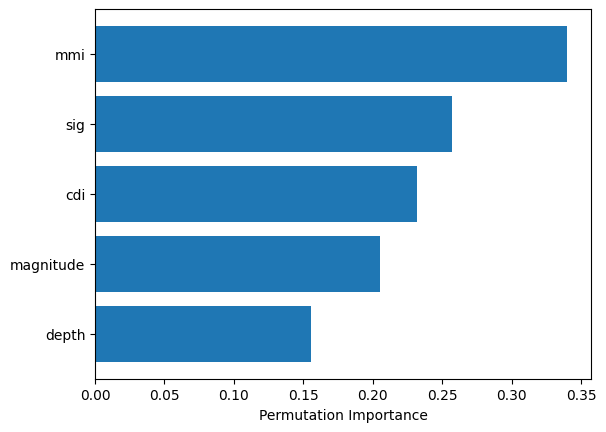

In [365]:
perm_importance = permutation_importance(clf_svm, X_test_scaled, y_test)

feature_names = list(X.columns.values)
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")


In [366]:
print(classification_report(y_test, y_pred, target_names=le.classes_))


              precision    recall  f1-score   support

       green       0.98      0.85      0.91        65
      orange       0.86      0.86      0.86        65
         red       0.84      0.98      0.91        65
      yellow       0.87      0.85      0.86        65

    accuracy                           0.88       260
   macro avg       0.89      0.88      0.88       260
weighted avg       0.89      0.88      0.88       260

